In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
from PIL import Image
import cv2

Connect to the shared folder in Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

def load_csv_from_drive(file_path):

    # Check if the file exists before attempting to load
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        print("CSV file loaded successfully!")
        print(df.head()) # Display the first few rows of the dataframe
    else:
        print(f"File not found at: {file_path}")
        print("Please ensure the folder and file names are correct and Google Drive is mounted.")
    return df

Mounted at /content/drive


In [38]:
working_path = '/content/drive/My Drive/DATASCI 281/'
source_path = '/content/drive/My Drive/DATASCI 281/ISIC_2019_resized/'
target_path = '/content/drive/My Drive/DATASCI 281/features/contour/'
source_metadata_file = 'resampled_metadata_resized.csv'
target_metadata_file = 'resampled_metadata_resized_with_metrics.csv'

In [4]:
# Load the metadata file
metadata_df = load_csv_from_drive(working_path + source_metadata_file)

CSV file loaded successfully!
                                image category augmentation_method   width  \
0  ISIC_0068778_preprocessed_rot0.jpg      MEL                rot0  1024.0   
1  ISIC_0058285_preprocessed_rot0.jpg      MEL                rot0  1024.0   
2  ISIC_0073194_preprocessed_rot0.jpg      MEL                rot0  1024.0   
3  ISIC_0058003_preprocessed_rot0.jpg      MEL                rot0  1024.0   
4  ISIC_0070105_preprocessed_rot0.jpg      MEL                rot0  1024.0   

   height  cropped_width  cropped_height  resized_width  resized_height  \
0  1024.0         1024.0          1024.0            400             400   
1  1024.0         1024.0          1024.0            400             400   
2  1024.0          614.0           614.0            400             400   
3  1024.0         1024.0          1024.0            400             400   
4  1024.0          707.0           707.0            400             400   

   resized_ratio  
0       0.390625  
1       0.39

In [5]:
def open_image_array(im_index, folder_path ):
    im = Image.open(folder_path + metadata_df.loc[im_index, 'image'])
    return np.array(im)

In [6]:
def DullRazor(img, hair_thresh=10, inpaint_radius=3, display=True):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Morphological black-hat filtering to detect hair
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # Threshold the black-hat image to create hair mask
    _, hair_mask = cv2.threshold(blackhat, hair_thresh, 255, cv2.THRESH_BINARY)

    # Clean the mask (morphological closing to fill small gaps)
    kernel_small = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    hair_mask_clean = cv2.morphologyEx(hair_mask, cv2.MORPH_CLOSE, kernel_small)

    # Inpaint the original image using the mask
    inpainted = cv2.inpaint(img, hair_mask_clean, inpaint_radius, cv2.INPAINT_TELEA)

    if display:
        # Show results
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 3, 1); plt.imshow(img); plt.title('Original Image'); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(blackhat, cmap='gray'); plt.title('Black-Hat Filter'); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(inpainted); plt.title('Inpainted Image (DullRazor)'); plt.axis('off')
        plt.show()

    return inpainted


In [66]:
def safe_compute(func, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except:
        return np.nan

def get_edges(im, display = False):
    # transform into grayscale
    im_gs = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2GRAY)

    # blur Image and invert it to get white objects in clear background
    blured_g = cv2.GaussianBlur(np.array(im_gs), (5, 5), 0)
    blured_g = 255 - blured_g

    # Detect edges
    otsu_thresh, img_o_th = cv2.threshold(blured_g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contour_otsu = cv2.findContours(img_o_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_otsu = max(contour_otsu[0], key=cv2.contourArea)
    # write the contour in the image
    im_o = im.copy()
    cv2.drawContours(im_o, [contour_otsu], 0, (0, 0, 255), 3)

    # calculate metrics
    contour_area = safe_compute(lambda: cv2.contourArea(contour_otsu))
    contour_perimeter = safe_compute(lambda: cv2.arcLength(contour_otsu, True))
    contour_convex_hull = safe_compute(lambda: cv2.convexHull(contour_otsu))
    contour_convex_hull_area = safe_compute(lambda: cv2.contourArea(contour_convex_hull))
    contour_convex_hull_perimeter = safe_compute(lambda: cv2.arcLength(contour_convex_hull, True))
    contour_solidity = safe_compute(lambda: float(contour_area) / contour_convex_hull_area)
    contour_extent = safe_compute(lambda: float(contour_area) / contour_perimeter)
    contour_equivalent_diameter = safe_compute(lambda: np.sqrt(4 * contour_area / np.pi))
    contour_orientation = safe_compute(lambda: cv2.fitEllipse(contour_otsu)[2])
    contour_major_axis_length = safe_compute(lambda: cv2.fitEllipse(contour_otsu)[1][0])
    contour_minor_axis_length = safe_compute(lambda: cv2.fitEllipse(contour_otsu)[1][1])
    contour_aspect_ratio = safe_compute(lambda: contour_major_axis_length / contour_minor_axis_length)
    contour_circularity = safe_compute(lambda: 4 * np.pi * contour_area / (contour_perimeter ** 2))

    metrics = {"area": contour_area,
               "perimeter": contour_perimeter,
               "solidity": contour_solidity,
               "extent": contour_extent,
               "equivalent_diameter": contour_equivalent_diameter,
               "orientation": contour_orientation,
               "major_axis_length": contour_major_axis_length,
               "minor_axis_length": contour_minor_axis_length,
               "aspect_ratio": contour_aspect_ratio,
               "circularity": contour_circularity
               }

    # Final image
    final_image = np.zeros(im_gs.shape)
    cv2.drawContours(final_image, [contour_otsu], 0, 255, -1)
    final_image = Image.fromarray(final_image.astype(np.uint8))

    # show image
    if display:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].axis('off')
        ax[1].axis('off')

        ax[0].imshow(im_o)
        ax[1].imshow(final_image, cmap='gray')

        ax[0].set_title('Contour')
        ax[1].set_title('Final Contour')

        plt.show()

    return final_image, metrics

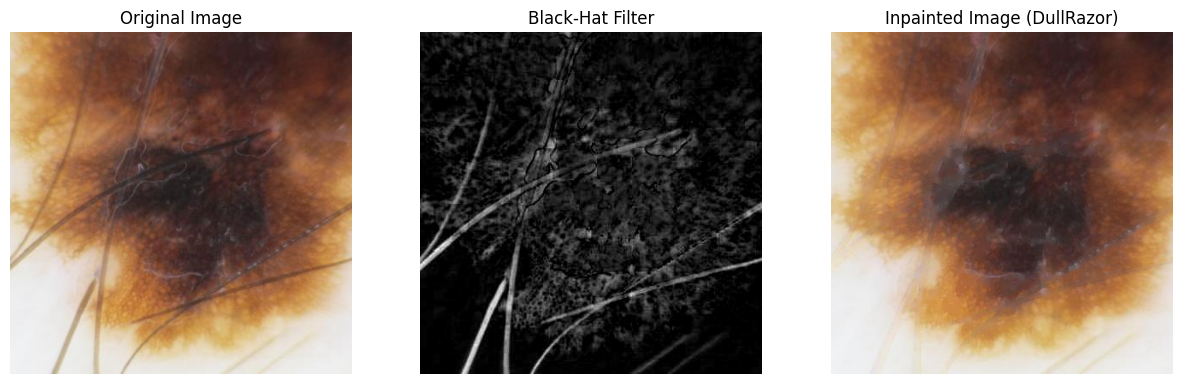

In [28]:
shaved = DullRazor(open_image_array(1,source_path), hair_thresh=15, inpaint_radius=3)

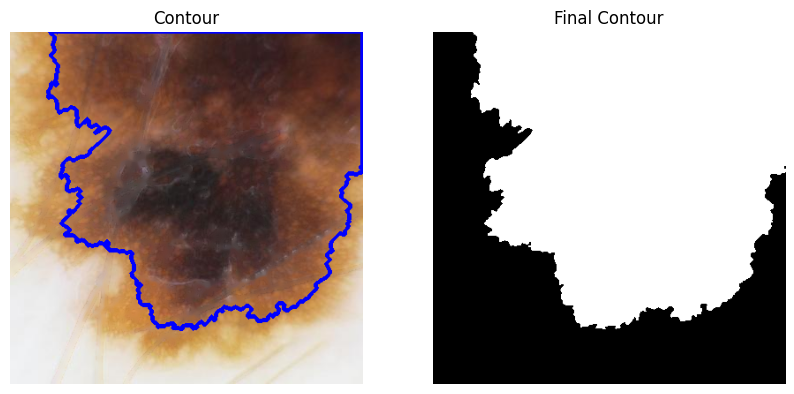

In [29]:
edges, area = get_edges(shaved, display=True)


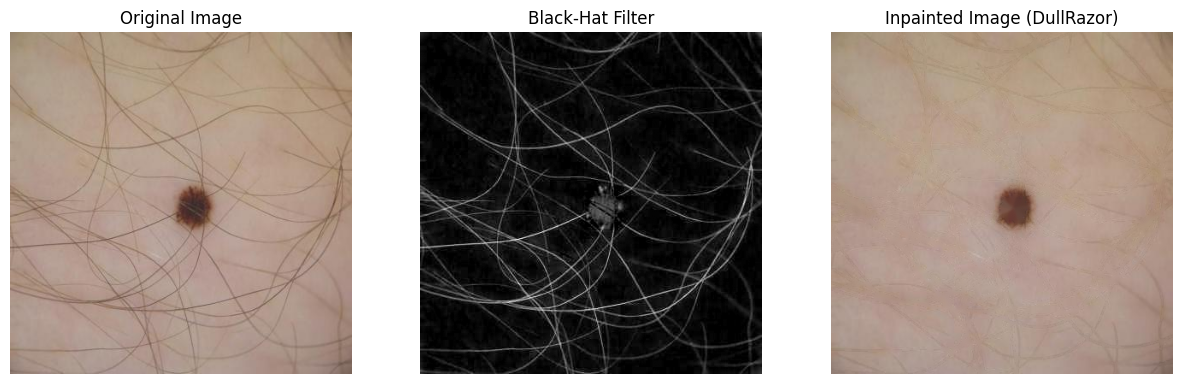

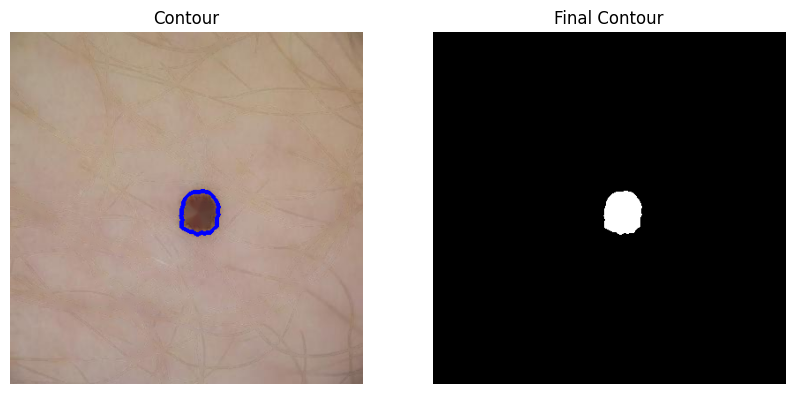

In [43]:
shaved = DullRazor(open_image_array(4,source_path), hair_thresh=15, inpaint_radius=3)
edges, metrics = get_edges(shaved, display = True)


In [44]:
metrics

{'area': 1686.0,
 'perimeter': 160.71067690849304,
 'solidity': 0.9634285714285714,
 'extent': 10.490902237690097,
 'equivalent_diameter': np.float64(46.33229837190774),
 'orientation': 7.984236240386963,
 'major_axis_length': 43.55336380004883,
 'minor_axis_length': 50.11424255371094,
 'aspect_ratio': 0.8690815540785565,
 'circularity': 0.8203099391640781}

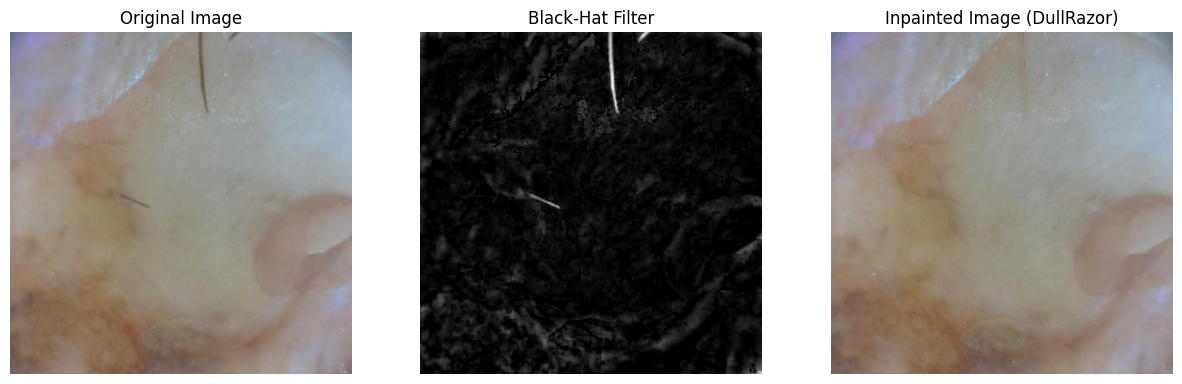

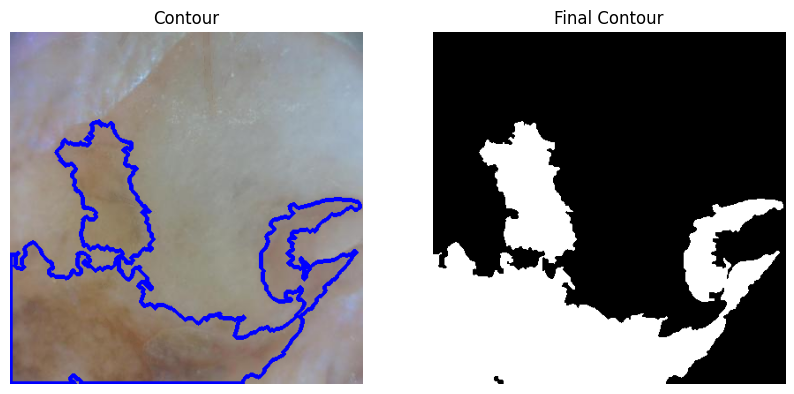

In [67]:
shaved = DullRazor(open_image_array(12,source_path), hair_thresh=15, inpaint_radius=3)
edges, area = get_edges(shaved, display = True)

In [68]:
area

{'area': 46810.0,
 'perimeter': 2643.0865577459335,
 'solidity': 0.5187508311538632,
 'extent': 17.710354533345406,
 'equivalent_diameter': np.float64(244.13181498742225),
 'orientation': 40.45022964477539,
 'major_axis_length': 302.4036865234375,
 'minor_axis_length': 320.5091247558594,
 'aspect_ratio': 0.9435103813465114,
 'circularity': 0.08420264486816989}

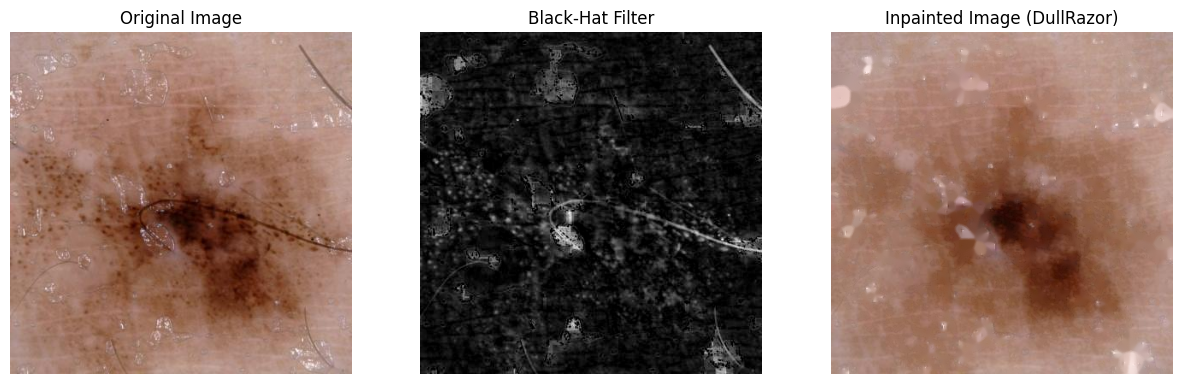

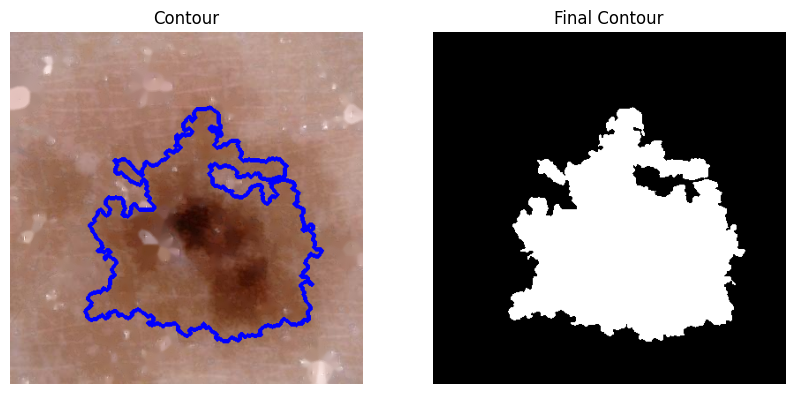

{'area': 41942.0,
 'perimeter': 1882.067223072052,
 'solidity': 0.7835671717077363,
 'extent': 22.285070100492536,
 'equivalent_diameter': np.float64(231.08918837817185),
 'orientation': 99.42053985595703,
 'major_axis_length': 238.9399871826172,
 'minor_axis_length': 245.8820037841797,
 'aspect_ratio': 0.9717668780361177,
 'circularity': 0.14879513686692722}

In [69]:
shaved = DullRazor(open_image_array(13,source_path), hair_thresh=15, inpaint_radius=3)
edges, metrics = get_edges(shaved, display = True)
metrics

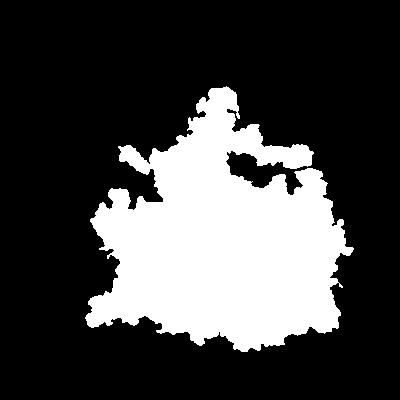

In [60]:
edges

In [70]:
# Process and add metrics to the metadata file (this process takes 45 min)
metadata_new = metadata_df.copy()
for idx in tqdm(metadata_df.index, desc="Processing Files"):
    shaved = DullRazor(open_image_array(idx, source_path), hair_thresh=15, inpaint_radius=3, display = False)
    edges, metrics = get_edges(shaved, display = False)
    metadata_new.loc[idx, 'area'] = metrics['area']
    metadata_new.loc[idx, 'perimeter'] = metrics['perimeter']
    metadata_new.loc[idx, 'solidity'] = metrics['solidity']
    metadata_new.loc[idx, 'extent'] = metrics['extent']
    metadata_new.loc[idx, 'equivalent_diameter'] = metrics['equivalent_diameter']
    metadata_new.loc[idx, 'orientation'] = metrics['orientation']
    metadata_new.loc[idx, 'major_axis_length'] = metrics['major_axis_length']
    metadata_new.loc[idx, 'minor_axis_length'] = metrics['minor_axis_length']
    metadata_new.loc[idx, 'aspect_ratio'] = metrics['aspect_ratio']
    metadata_new.loc[idx, 'circularity'] = metrics['circularity']
    file_name = metadata_df.loc[idx, 'image'].split('.')[0]+'.png'
    edges.save(target_path + file_name)
metadata_new.to_csv(working_path + target_metadata_file, index=False)

Processing Files: 100%|██████████| 8000/8000 [25:39<00:00,  5.20it/s]


In [71]:
metadata_new.head()

,image,category,augmentation_method,width,height,cropped_width,cropped_height,resized_width,resized_height,resized_ratio,area,perimeter,solidity,extent,equivalent_diameter,orientation,major_axis_length,minor_axis_length,aspect_ratio,circularity
0,ISIC_0068778_preprocessed_rot0.jpg,MEL,rot0,1024.0,1024.0,1024.0,1024.0,400,400,0.390625,72474.0,1136.028558,0.975004,63.795931,303.770905,52.576595,246.178574,375.023468,0.656435,0.705689
1,ISIC_0058285_preprocessed_rot0.jpg,MEL,rot0,1024.0,1024.0,1024.0,1024.0,400,400,0.390625,95499.0,1694.454965,0.917391,56.359716,348.702026,172.929916,339.253693,459.401398,0.738469,0.417973
2,ISIC_0073194_preprocessed_rot0.jpg,MEL,rot0,1024.0,1024.0,614.0,614.0,400,400,0.651466,3529.0,249.622364,0.939563,14.137355,67.031801,111.236549,55.239372,82.169350,0.672262,0.711696
3,ISIC_0058003_preprocessed_rot0.jpg,MEL,rot0,1024.0,1024.0,1024.0,1024.0,400,400,0.390625,24392.5,924.305689,0.865565,26.390079,176.231369,151.349457,159.648575,209.795822,0.760971,0.358786
4,ISIC_0070105_preprocessed_rot0.jpg,MEL,rot0,1024.0,1024.0,707.0,707.0,400,400,0.565771,1686.0,160.710677,0.963429,10.490902,46.332298,7.984236,43.553364,50.114243,0.869082,0.820310


# Component analysis



In [77]:
matrix = np.zeros((metadata_df.shape[0], 400*400))
for idx in tqdm(metadata_df.index, desc="Processing Files"):
    image = cv2.imread(target_path + metadata_df.loc[idx, 'image'].split('.')[0]+'.png')
    image = image[:,:,0].reshape(-1)
    matrix[idx, :] = image

Processing Files: 100%|██████████| 8000/8000 [01:14<00:00, 106.79it/s]


In [72]:
matrix.to_csv()

In [76]:
image[:,:,0].reshape(-1)


array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)